In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_ki = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/ki/ki_with_features.joblib')
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,log10ki_mean,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [3]:
data_ki.rename(columns={'log10ki_mean':'label'},inplace=True)
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,label,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [4]:
data_ki.shape

(11929, 10)

In [5]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [6]:
# Separate the dataset by unique proteins and drugs
unique_proteins = data_ki['Sequence'].unique()
unique_mols = data_ki['Smiles'].unique()
# Set the seed for reproducibility
torch.manual_seed(42)
# Function to perform a cold split
def cold_split(unique_items, test_size=0.2, val_size=0.1):
    train_items, test_items = train_test_split(unique_items, test_size=test_size, random_state=42)
    train_items, val_items = train_test_split(train_items, test_size=val_size / (1 - test_size), random_state=42)
    return train_items, val_items, test_items
# Cold split by proteins
train_proteins, val_proteins, test_proteins = cold_split(unique_proteins)
train_cold_protein = data_ki[data_ki['Sequence'].isin(train_proteins)]
val_cold_protein = data_ki[data_ki['Sequence'].isin(val_proteins)]
test_cold_protein = data_ki[data_ki['Sequence'].isin(test_proteins)]
# Cold split by molecules
train_mols, val_mols, test_mols = cold_split(unique_mols)
train_cold_mols = data_ki[data_ki['Smiles'].isin(train_mols)]
val_cold_mols = data_ki[data_ki['Smiles'].isin(val_mols)]
test_cold_mols = data_ki[data_ki['Smiles'].isin(test_mols)]

In [7]:
# cold protein
'''
train_dataset = MPI_Dataset(train_cold_protein)
val_dataset = MPI_Dataset(val_cold_protein)
test_dataset = MPI_Dataset(test_cold_protein)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

'''

# cold mols

'''
train_dataset = MPI_Dataset(train_cold_mols)
val_dataset = MPI_Dataset(val_cold_mols)
test_dataset = MPI_Dataset(test_cold_mols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

'''

'\ntrain_dataset = MPI_Dataset(train_cold_mols)\nval_dataset = MPI_Dataset(val_cold_mols)\ntest_dataset = MPI_Dataset(test_cold_mols)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=32)\ntest_loader = DataLoader(test_dataset, batch_size=32)\n\n'

In [8]:
# Load data_ki
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_ki, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define CNN Model for Regression
class CNNRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, out_dim=1):
        super(CNNRegressor, self).__init__()

        self.mol_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.protein_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        with torch.no_grad():
            dummy_mol = torch.zeros(1, 1, mol_input_dim)
            dummy_protein = torch.zeros(1, 1, protein_input_dim)
    
            mol_flatten_len = self.mol_conv(dummy_mol).view(1, -1).size(1)
            protein_flatten_len = self.protein_conv(dummy_protein).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(mol_flatten_len + protein_flatten_len, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim)
        )

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_input = mol_input.unsqueeze(1)
        protein_input = protein_input.unsqueeze(1)

        mol_out = self.mol_conv(mol_input)
        protein_out = self.protein_conv(protein_input)

        # Flatten
        mol_out = mol_out.view(mol_out.size(0), -1)
        protein_out = protein_out.view(protein_out.size(0), -1)

        combined = torch.cat([mol_out, protein_out], dim=1)
        output = self.fc(combined).squeeze()
        return output


In [10]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)




Training Epoch 1: 100%|██████████| 261/261 [00:08<00:00, 30.43it/s]


Epoch 0 - Train Loss: 3.3708, Train MSE: 3.3710, Train MAE: 1.4650


/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_17517/3486802603.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.9432, Validation MSE: 2.9446, Validation MAE: 1.3357


Training Epoch 11: 100%|██████████| 261/261 [00:08<00:00, 30.19it/s]


Epoch 10 - Train Loss: 2.3449, Train MSE: 2.3450, Train MAE: 1.2096
Epoch 10 - Validation Loss: 2.4539, Validation MSE: 2.4548, Validation MAE: 1.2242


Training Epoch 21: 100%|██████████| 261/261 [00:08<00:00, 31.25it/s]


Epoch 20 - Train Loss: 2.0732, Train MSE: 2.0733, Train MAE: 1.1321
Epoch 20 - Validation Loss: 2.3720, Validation MSE: 2.3727, Validation MAE: 1.2185


Training Epoch 31: 100%|██████████| 261/261 [00:09<00:00, 28.94it/s]


Epoch 30 - Train Loss: 1.8586, Train MSE: 1.8587, Train MAE: 1.0674
Epoch 30 - Validation Loss: 2.1537, Validation MSE: 2.1547, Validation MAE: 1.1369


Training Epoch 41: 100%|██████████| 261/261 [00:11<00:00, 22.82it/s]


Epoch 40 - Train Loss: 1.6394, Train MSE: 1.6392, Train MAE: 0.9990
Epoch 40 - Validation Loss: 2.1492, Validation MSE: 2.1506, Validation MAE: 1.1283


Training Epoch 51: 100%|██████████| 261/261 [00:13<00:00, 19.80it/s]


Epoch 50 - Train Loss: 1.5047, Train MSE: 1.5048, Train MAE: 0.9529
Epoch 50 - Validation Loss: 2.0610, Validation MSE: 2.0623, Validation MAE: 1.1068


Training Epoch 61: 100%|██████████| 261/261 [00:13<00:00, 19.87it/s]


Epoch 60 - Train Loss: 1.3976, Train MSE: 1.3977, Train MAE: 0.9138
Epoch 60 - Validation Loss: 1.9750, Validation MSE: 1.9765, Validation MAE: 1.0810


Training Epoch 71: 100%|██████████| 261/261 [02:24<00:00,  1.81it/s] 


Epoch 70 - Train Loss: 1.2926, Train MSE: 1.2925, Train MAE: 0.8805
Epoch 70 - Validation Loss: 1.9766, Validation MSE: 1.9783, Validation MAE: 1.0697


Training Epoch 81: 100%|██████████| 261/261 [00:12<00:00, 20.36it/s]


Epoch 80 - Train Loss: 1.1928, Train MSE: 1.1928, Train MAE: 0.8455
Epoch 80 - Validation Loss: 2.0021, Validation MSE: 2.0038, Validation MAE: 1.0853


Training Epoch 91: 100%|██████████| 261/261 [00:12<00:00, 20.36it/s]


Epoch 90 - Train Loss: 1.0955, Train MSE: 1.0955, Train MAE: 0.8095
Epoch 90 - Validation Loss: 1.8985, Validation MSE: 1.9001, Validation MAE: 1.0517


Training Epoch 101: 100%|██████████| 261/261 [00:16<00:00, 15.55it/s]


Epoch 100 - Train Loss: 1.0347, Train MSE: 1.0348, Train MAE: 0.7847
Epoch 100 - Validation Loss: 1.9099, Validation MSE: 1.9116, Validation MAE: 1.0498


Training Epoch 111: 100%|██████████| 261/261 [00:24<00:00, 10.49it/s]


Epoch 110 - Train Loss: 0.9574, Train MSE: 0.9574, Train MAE: 0.7520
Epoch 110 - Validation Loss: 1.8938, Validation MSE: 1.8956, Validation MAE: 1.0443


Training Epoch 121: 100%|██████████| 261/261 [17:10<00:00,  3.95s/it]  


Epoch 120 - Train Loss: 0.8962, Train MSE: 0.8963, Train MAE: 0.7308
Epoch 120 - Validation Loss: 1.8539, Validation MSE: 1.8557, Validation MAE: 1.0233


Training Epoch 131: 100%|██████████| 261/261 [00:19<00:00, 13.59it/s]


Epoch 130 - Train Loss: 0.8575, Train MSE: 0.8575, Train MAE: 0.7100
Epoch 130 - Validation Loss: 1.8924, Validation MSE: 1.8941, Validation MAE: 1.0381


Training Epoch 141: 100%|██████████| 261/261 [00:19<00:00, 13.71it/s]


Epoch 140 - Train Loss: 0.8079, Train MSE: 0.8079, Train MAE: 0.6918
Epoch 140 - Validation Loss: 2.0996, Validation MSE: 2.1016, Validation MAE: 1.1021


Training Epoch 151: 100%|██████████| 261/261 [00:20<00:00, 13.00it/s]


Epoch 150 - Train Loss: 0.7523, Train MSE: 0.7523, Train MAE: 0.6654
Epoch 150 - Validation Loss: 1.8728, Validation MSE: 1.8746, Validation MAE: 1.0344


Training Epoch 161: 100%|██████████| 261/261 [00:17<00:00, 15.23it/s]


Epoch 160 - Train Loss: 0.7329, Train MSE: 0.7329, Train MAE: 0.6577
Epoch 160 - Validation Loss: 2.0430, Validation MSE: 2.0450, Validation MAE: 1.0817


Training Epoch 171: 100%|██████████| 261/261 [00:17<00:00, 15.10it/s]


Epoch 170 - Train Loss: 0.7091, Train MSE: 0.7091, Train MAE: 0.6439
Epoch 170 - Validation Loss: 1.8763, Validation MSE: 1.8782, Validation MAE: 1.0285


Training Epoch 181: 100%|██████████| 261/261 [00:17<00:00, 14.74it/s]


Epoch 180 - Train Loss: 0.6886, Train MSE: 0.6887, Train MAE: 0.6308
Epoch 180 - Validation Loss: 2.0836, Validation MSE: 2.0855, Validation MAE: 1.0877


Training Epoch 191: 100%|██████████| 261/261 [00:18<00:00, 14.01it/s]


Epoch 190 - Train Loss: 0.6304, Train MSE: 0.6304, Train MAE: 0.6034
Epoch 190 - Validation Loss: 1.9096, Validation MSE: 1.9115, Validation MAE: 1.0384


Training Epoch 201: 100%|██████████| 261/261 [00:18<00:00, 14.23it/s]


Epoch 200 - Train Loss: 0.6362, Train MSE: 0.6361, Train MAE: 0.6081
Epoch 200 - Validation Loss: 1.9326, Validation MSE: 1.9345, Validation MAE: 1.0406


Training Epoch 211: 100%|██████████| 261/261 [00:18<00:00, 14.34it/s]


Epoch 210 - Train Loss: 0.5748, Train MSE: 0.5749, Train MAE: 0.5781
Epoch 210 - Validation Loss: 1.8519, Validation MSE: 1.8537, Validation MAE: 1.0223


Training Epoch 221: 100%|██████████| 261/261 [00:18<00:00, 14.46it/s]


Epoch 220 - Train Loss: 0.5768, Train MSE: 0.5768, Train MAE: 0.5789
Epoch 220 - Validation Loss: 1.9481, Validation MSE: 1.9499, Validation MAE: 1.0417


Training Epoch 231: 100%|██████████| 261/261 [00:18<00:00, 14.36it/s]


Epoch 230 - Train Loss: 0.5650, Train MSE: 0.5651, Train MAE: 0.5725
Epoch 230 - Validation Loss: 1.8541, Validation MSE: 1.8559, Validation MAE: 1.0198


Training Epoch 241: 100%|██████████| 261/261 [00:36<00:00,  7.16it/s]


Epoch 240 - Train Loss: 0.5377, Train MSE: 0.5377, Train MAE: 0.5547
Epoch 240 - Validation Loss: 1.8784, Validation MSE: 1.8801, Validation MAE: 1.0262


Training Epoch 251: 100%|██████████| 261/261 [01:38<00:00,  2.66it/s]


Epoch 250 - Train Loss: 0.5219, Train MSE: 0.5219, Train MAE: 0.5467
Epoch 250 - Validation Loss: 1.9385, Validation MSE: 1.9403, Validation MAE: 1.0366


Training Epoch 261: 100%|██████████| 261/261 [00:26<00:00,  9.98it/s]


Epoch 260 - Train Loss: 0.5187, Train MSE: 0.5187, Train MAE: 0.5484
Epoch 260 - Validation Loss: 1.9296, Validation MSE: 1.9316, Validation MAE: 1.0339


Training Epoch 271: 100%|██████████| 261/261 [00:29<00:00,  8.96it/s]


Epoch 270 - Train Loss: 0.5025, Train MSE: 0.5026, Train MAE: 0.5385
Epoch 270 - Validation Loss: 1.8581, Validation MSE: 1.8601, Validation MAE: 1.0099


Training Epoch 281: 100%|██████████| 261/261 [00:17<00:00, 14.97it/s]


Epoch 280 - Train Loss: 0.5033, Train MSE: 0.5032, Train MAE: 0.5374
Epoch 280 - Validation Loss: 1.9093, Validation MSE: 1.9112, Validation MAE: 1.0308


Training Epoch 291: 100%|██████████| 261/261 [00:17<00:00, 15.02it/s]


Epoch 290 - Train Loss: 0.4754, Train MSE: 0.4754, Train MAE: 0.5220
Epoch 290 - Validation Loss: 2.0183, Validation MSE: 2.0200, Validation MAE: 1.0563


Training Epoch 301: 100%|██████████| 261/261 [00:27<00:00,  9.66it/s]


Epoch 300 - Train Loss: 0.4613, Train MSE: 0.4613, Train MAE: 0.5133
Epoch 300 - Validation Loss: 1.9083, Validation MSE: 1.9102, Validation MAE: 1.0208


Training Epoch 311: 100%|██████████| 261/261 [00:26<00:00,  9.85it/s]


Epoch 310 - Train Loss: 0.4653, Train MSE: 0.4653, Train MAE: 0.5136
Epoch 310 - Validation Loss: 1.8695, Validation MSE: 1.8713, Validation MAE: 1.0192


Training Epoch 321: 100%|██████████| 261/261 [16:55<00:00,  3.89s/it]   


Epoch 320 - Train Loss: 0.4371, Train MSE: 0.4371, Train MAE: 0.4985
Epoch 320 - Validation Loss: 1.8576, Validation MSE: 1.8593, Validation MAE: 1.0094


Training Epoch 331: 100%|██████████| 261/261 [00:25<00:00, 10.33it/s]


Epoch 330 - Train Loss: 0.4434, Train MSE: 0.4434, Train MAE: 0.5056
Epoch 330 - Validation Loss: 1.9556, Validation MSE: 1.9574, Validation MAE: 1.0392


Training Epoch 341: 100%|██████████| 261/261 [00:25<00:00, 10.24it/s]


Epoch 340 - Train Loss: 0.4317, Train MSE: 0.4317, Train MAE: 0.4942
Epoch 340 - Validation Loss: 1.8837, Validation MSE: 1.8854, Validation MAE: 1.0158


Training Epoch 351: 100%|██████████| 261/261 [00:26<00:00, 10.03it/s]


Epoch 350 - Train Loss: 0.4339, Train MSE: 0.4339, Train MAE: 0.4970
Epoch 350 - Validation Loss: 1.8988, Validation MSE: 1.9006, Validation MAE: 1.0225


Training Epoch 361: 100%|██████████| 261/261 [16:05<00:00,  3.70s/it]   


Epoch 360 - Train Loss: 0.4315, Train MSE: 0.4315, Train MAE: 0.4943
Epoch 360 - Validation Loss: 1.8966, Validation MSE: 1.8987, Validation MAE: 1.0176


Training Epoch 371: 100%|██████████| 261/261 [16:46<00:00,  3.86s/it]  


Epoch 370 - Train Loss: 0.4185, Train MSE: 0.4186, Train MAE: 0.4856
Epoch 370 - Validation Loss: 1.8984, Validation MSE: 1.9002, Validation MAE: 1.0244


Training Epoch 381: 100%|██████████| 261/261 [16:55<00:00,  3.89s/it]   


Epoch 380 - Train Loss: 0.4268, Train MSE: 0.4268, Train MAE: 0.4931
Epoch 380 - Validation Loss: 1.9084, Validation MSE: 1.9103, Validation MAE: 1.0245


Training Epoch 391: 100%|██████████| 261/261 [00:23<00:00, 10.94it/s]


Epoch 390 - Train Loss: 0.3970, Train MSE: 0.3969, Train MAE: 0.4730
Epoch 390 - Validation Loss: 1.9093, Validation MSE: 1.9111, Validation MAE: 1.0202


Training Epoch 401: 100%|██████████| 261/261 [00:21<00:00, 12.24it/s]


Epoch 400 - Train Loss: 0.3988, Train MSE: 0.3988, Train MAE: 0.4735
Epoch 400 - Validation Loss: 2.0588, Validation MSE: 2.0606, Validation MAE: 1.0676


Training Epoch 411: 100%|██████████| 261/261 [00:21<00:00, 12.04it/s]


Epoch 410 - Train Loss: 0.3992, Train MSE: 0.3993, Train MAE: 0.4755
Epoch 410 - Validation Loss: 1.8957, Validation MSE: 1.8976, Validation MAE: 1.0135


Training Epoch 421: 100%|██████████| 261/261 [01:17<00:00,  3.36it/s]


Epoch 420 - Train Loss: 0.4080, Train MSE: 0.4080, Train MAE: 0.4806
Epoch 420 - Validation Loss: 1.9277, Validation MSE: 1.9295, Validation MAE: 1.0292


Training Epoch 431: 100%|██████████| 261/261 [01:04<00:00,  4.05it/s]


Epoch 430 - Train Loss: 0.4018, Train MSE: 0.4018, Train MAE: 0.4728
Epoch 430 - Validation Loss: 1.9711, Validation MSE: 1.9727, Validation MAE: 1.0340


Training Epoch 441: 100%|██████████| 261/261 [00:32<00:00,  8.05it/s]


Epoch 440 - Train Loss: 0.3970, Train MSE: 0.3971, Train MAE: 0.4717
Epoch 440 - Validation Loss: 1.8956, Validation MSE: 1.8974, Validation MAE: 1.0192


Training Epoch 451: 100%|██████████| 261/261 [00:33<00:00,  7.77it/s]


Epoch 450 - Train Loss: 0.3844, Train MSE: 0.3844, Train MAE: 0.4625
Epoch 450 - Validation Loss: 1.9117, Validation MSE: 1.9133, Validation MAE: 1.0254


Training Epoch 461: 100%|██████████| 261/261 [00:38<00:00,  6.78it/s]


Epoch 460 - Train Loss: 0.3800, Train MSE: 0.3800, Train MAE: 0.4609
Epoch 460 - Validation Loss: 1.9585, Validation MSE: 1.9601, Validation MAE: 1.0344


Training Epoch 471: 100%|██████████| 261/261 [00:20<00:00, 12.63it/s]


Epoch 470 - Train Loss: 0.3758, Train MSE: 0.3759, Train MAE: 0.4581
Epoch 470 - Validation Loss: 1.9167, Validation MSE: 1.9182, Validation MAE: 1.0271


Training Epoch 481: 100%|██████████| 261/261 [00:21<00:00, 12.41it/s]


Epoch 480 - Train Loss: 0.3751, Train MSE: 0.3752, Train MAE: 0.4597
Epoch 480 - Validation Loss: 1.9255, Validation MSE: 1.9272, Validation MAE: 1.0259


Training Epoch 491: 100%|██████████| 261/261 [00:13<00:00, 18.89it/s]


Epoch 490 - Train Loss: 0.3793, Train MSE: 0.3793, Train MAE: 0.4573
Epoch 490 - Validation Loss: 1.9940, Validation MSE: 1.9958, Validation MAE: 1.0368


Training Epoch 501: 100%|██████████| 261/261 [00:14<00:00, 17.83it/s]


Epoch 500 - Train Loss: 0.3702, Train MSE: 0.3701, Train MAE: 0.4505
Epoch 500 - Validation Loss: 1.9372, Validation MSE: 1.9390, Validation MAE: 1.0339


Training Epoch 511: 100%|██████████| 261/261 [00:15<00:00, 16.88it/s]


Epoch 510 - Train Loss: 0.3643, Train MSE: 0.3643, Train MAE: 0.4513
Epoch 510 - Validation Loss: 1.9732, Validation MSE: 1.9748, Validation MAE: 1.0335


Training Epoch 521: 100%|██████████| 261/261 [00:13<00:00, 19.48it/s]


Epoch 520 - Train Loss: 0.3604, Train MSE: 0.3605, Train MAE: 0.4461
Epoch 520 - Validation Loss: 2.0079, Validation MSE: 2.0096, Validation MAE: 1.0393


Training Epoch 531: 100%|██████████| 261/261 [00:14<00:00, 18.50it/s]


Epoch 530 - Train Loss: 0.3861, Train MSE: 0.3861, Train MAE: 0.4611
Epoch 530 - Validation Loss: 1.9595, Validation MSE: 1.9611, Validation MAE: 1.0268


Training Epoch 541: 100%|██████████| 261/261 [00:14<00:00, 18.59it/s]


Epoch 540 - Train Loss: 0.3609, Train MSE: 0.3609, Train MAE: 0.4486
Epoch 540 - Validation Loss: 1.9425, Validation MSE: 1.9442, Validation MAE: 1.0288


Training Epoch 551: 100%|██████████| 261/261 [00:14<00:00, 18.44it/s]


Epoch 550 - Train Loss: 0.3595, Train MSE: 0.3595, Train MAE: 0.4464
Epoch 550 - Validation Loss: 1.9476, Validation MSE: 1.9492, Validation MAE: 1.0274


Training Epoch 561: 100%|██████████| 261/261 [00:13<00:00, 18.87it/s]


Epoch 560 - Train Loss: 0.3518, Train MSE: 0.3518, Train MAE: 0.4372
Epoch 560 - Validation Loss: 1.9430, Validation MSE: 1.9447, Validation MAE: 1.0224


Training Epoch 571: 100%|██████████| 261/261 [00:14<00:00, 18.55it/s]


Epoch 570 - Train Loss: 0.3529, Train MSE: 0.3529, Train MAE: 0.4359
Epoch 570 - Validation Loss: 1.9655, Validation MSE: 1.9670, Validation MAE: 1.0305


Training Epoch 581: 100%|██████████| 261/261 [00:14<00:00, 18.57it/s]


Epoch 580 - Train Loss: 0.3559, Train MSE: 0.3559, Train MAE: 0.4428
Epoch 580 - Validation Loss: 1.8876, Validation MSE: 1.8893, Validation MAE: 1.0124


Training Epoch 591: 100%|██████████| 261/261 [00:13<00:00, 18.71it/s]


Epoch 590 - Train Loss: 0.3513, Train MSE: 0.3513, Train MAE: 0.4372
Epoch 590 - Validation Loss: 1.9114, Validation MSE: 1.9131, Validation MAE: 1.0150


Training Epoch 601: 100%|██████████| 261/261 [00:13<00:00, 18.89it/s]


Epoch 600 - Train Loss: 0.3344, Train MSE: 0.3345, Train MAE: 0.4305
Epoch 600 - Validation Loss: 1.9940, Validation MSE: 1.9958, Validation MAE: 1.0336


Training Epoch 611: 100%|██████████| 261/261 [00:13<00:00, 18.74it/s]


Epoch 610 - Train Loss: 0.3431, Train MSE: 0.3431, Train MAE: 0.4341
Epoch 610 - Validation Loss: 2.1403, Validation MSE: 2.1420, Validation MAE: 1.0835


Training Epoch 621: 100%|██████████| 261/261 [00:14<00:00, 18.40it/s]


Epoch 620 - Train Loss: 0.3638, Train MSE: 0.3638, Train MAE: 0.4450
Epoch 620 - Validation Loss: 1.9951, Validation MSE: 1.9968, Validation MAE: 1.0363


Training Epoch 631: 100%|██████████| 261/261 [00:13<00:00, 18.84it/s]


Epoch 630 - Train Loss: 0.3355, Train MSE: 0.3355, Train MAE: 0.4323
Epoch 630 - Validation Loss: 1.9296, Validation MSE: 1.9313, Validation MAE: 1.0241


Training Epoch 641: 100%|██████████| 261/261 [00:14<00:00, 18.26it/s]


Epoch 640 - Train Loss: 0.3387, Train MSE: 0.3387, Train MAE: 0.4280
Epoch 640 - Validation Loss: 1.9484, Validation MSE: 1.9501, Validation MAE: 1.0236


Training Epoch 651: 100%|██████████| 261/261 [00:13<00:00, 18.65it/s]


Epoch 650 - Train Loss: 0.3330, Train MSE: 0.3330, Train MAE: 0.4287
Epoch 650 - Validation Loss: 1.9806, Validation MSE: 1.9824, Validation MAE: 1.0371


Training Epoch 661: 100%|██████████| 261/261 [00:14<00:00, 18.63it/s]


Epoch 660 - Train Loss: 0.3526, Train MSE: 0.3526, Train MAE: 0.4374
Epoch 660 - Validation Loss: 1.9081, Validation MSE: 1.9098, Validation MAE: 1.0196


Training Epoch 671: 100%|██████████| 261/261 [00:14<00:00, 18.63it/s]


Epoch 670 - Train Loss: 0.3287, Train MSE: 0.3287, Train MAE: 0.4277
Epoch 670 - Validation Loss: 1.9516, Validation MSE: 1.9532, Validation MAE: 1.0269


Training Epoch 681: 100%|██████████| 261/261 [00:14<00:00, 18.58it/s]


Epoch 680 - Train Loss: 0.3324, Train MSE: 0.3324, Train MAE: 0.4243
Epoch 680 - Validation Loss: 1.9740, Validation MSE: 1.9757, Validation MAE: 1.0305


Training Epoch 691: 100%|██████████| 261/261 [00:14<00:00, 17.96it/s]


Epoch 690 - Train Loss: 0.3247, Train MSE: 0.3247, Train MAE: 0.4172
Epoch 690 - Validation Loss: 2.0216, Validation MSE: 2.0232, Validation MAE: 1.0425


Training Epoch 701: 100%|██████████| 261/261 [00:13<00:00, 18.84it/s]


Epoch 700 - Train Loss: 0.3267, Train MSE: 0.3268, Train MAE: 0.4200
Epoch 700 - Validation Loss: 1.9563, Validation MSE: 1.9578, Validation MAE: 1.0297


Training Epoch 711: 100%|██████████| 261/261 [00:14<00:00, 18.20it/s]


Epoch 710 - Train Loss: 0.3252, Train MSE: 0.3251, Train MAE: 0.4206
Epoch 710 - Validation Loss: 1.9447, Validation MSE: 1.9462, Validation MAE: 1.0252


Training Epoch 721: 100%|██████████| 261/261 [00:14<00:00, 18.58it/s]


Epoch 720 - Train Loss: 0.3174, Train MSE: 0.3174, Train MAE: 0.4118
Epoch 720 - Validation Loss: 1.9274, Validation MSE: 1.9291, Validation MAE: 1.0242


Training Epoch 731: 100%|██████████| 261/261 [00:14<00:00, 18.08it/s]


Epoch 730 - Train Loss: 0.3293, Train MSE: 0.3293, Train MAE: 0.4219
Epoch 730 - Validation Loss: 1.9244, Validation MSE: 1.9262, Validation MAE: 1.0255


Training Epoch 741: 100%|██████████| 261/261 [00:13<00:00, 18.81it/s]


Epoch 740 - Train Loss: 0.3145, Train MSE: 0.3145, Train MAE: 0.4145
Epoch 740 - Validation Loss: 1.9375, Validation MSE: 1.9390, Validation MAE: 1.0227


Training Epoch 751: 100%|██████████| 261/261 [00:13<00:00, 18.73it/s]


Epoch 750 - Train Loss: 0.3199, Train MSE: 0.3199, Train MAE: 0.4149
Epoch 750 - Validation Loss: 1.9776, Validation MSE: 1.9794, Validation MAE: 1.0293


Training Epoch 761: 100%|██████████| 261/261 [00:14<00:00, 18.31it/s]


Epoch 760 - Train Loss: 0.3279, Train MSE: 0.3279, Train MAE: 0.4205
Epoch 760 - Validation Loss: 1.9132, Validation MSE: 1.9150, Validation MAE: 1.0185


Training Epoch 771: 100%|██████████| 261/261 [00:13<00:00, 18.71it/s]


Epoch 770 - Train Loss: 0.3061, Train MSE: 0.3061, Train MAE: 0.4093
Epoch 770 - Validation Loss: 1.8824, Validation MSE: 1.8839, Validation MAE: 1.0125


Training Epoch 781: 100%|██████████| 261/261 [00:14<00:00, 18.20it/s]


Epoch 780 - Train Loss: 0.3209, Train MSE: 0.3208, Train MAE: 0.4167
Epoch 780 - Validation Loss: 2.0400, Validation MSE: 2.0415, Validation MAE: 1.0433


Training Epoch 791: 100%|██████████| 261/261 [00:12<00:00, 21.66it/s]


Epoch 790 - Train Loss: 0.3239, Train MSE: 0.3239, Train MAE: 0.4214
Epoch 790 - Validation Loss: 1.9169, Validation MSE: 1.9185, Validation MAE: 1.0147


Training Epoch 801: 100%|██████████| 261/261 [00:11<00:00, 23.00it/s]


Epoch 800 - Train Loss: 0.3221, Train MSE: 0.3220, Train MAE: 0.4171
Epoch 800 - Validation Loss: 1.9002, Validation MSE: 1.9021, Validation MAE: 1.0149


Training Epoch 811: 100%|██████████| 261/261 [00:11<00:00, 22.83it/s]


Epoch 810 - Train Loss: 0.3146, Train MSE: 0.3146, Train MAE: 0.4131
Epoch 810 - Validation Loss: 1.9383, Validation MSE: 1.9400, Validation MAE: 1.0232


Training Epoch 821: 100%|██████████| 261/261 [00:11<00:00, 22.35it/s]


Epoch 820 - Train Loss: 0.3155, Train MSE: 0.3154, Train MAE: 0.4126
Epoch 820 - Validation Loss: 1.8994, Validation MSE: 1.9009, Validation MAE: 1.0126


Training Epoch 831: 100%|██████████| 261/261 [00:11<00:00, 22.35it/s]


Epoch 830 - Train Loss: 0.3156, Train MSE: 0.3156, Train MAE: 0.4160
Epoch 830 - Validation Loss: 1.9512, Validation MSE: 1.9529, Validation MAE: 1.0231


Training Epoch 841: 100%|██████████| 261/261 [00:11<00:00, 22.45it/s]


Epoch 840 - Train Loss: 0.3183, Train MSE: 0.3183, Train MAE: 0.4144
Epoch 840 - Validation Loss: 1.9199, Validation MSE: 1.9216, Validation MAE: 1.0171


Training Epoch 851: 100%|██████████| 261/261 [00:11<00:00, 23.07it/s]


Epoch 850 - Train Loss: 0.3112, Train MSE: 0.3113, Train MAE: 0.4091
Epoch 850 - Validation Loss: 1.9297, Validation MSE: 1.9313, Validation MAE: 1.0183


Training Epoch 861: 100%|██████████| 261/261 [00:11<00:00, 23.12it/s]


Epoch 860 - Train Loss: 0.3143, Train MSE: 0.3143, Train MAE: 0.4084
Epoch 860 - Validation Loss: 1.9569, Validation MSE: 1.9585, Validation MAE: 1.0226


Training Epoch 871: 100%|██████████| 261/261 [00:11<00:00, 23.06it/s]


Epoch 870 - Train Loss: 0.3117, Train MSE: 0.3117, Train MAE: 0.4096
Epoch 870 - Validation Loss: 1.9423, Validation MSE: 1.9438, Validation MAE: 1.0182


Training Epoch 881: 100%|██████████| 261/261 [00:11<00:00, 23.18it/s]


Epoch 880 - Train Loss: 0.3064, Train MSE: 0.3064, Train MAE: 0.4035
Epoch 880 - Validation Loss: 2.0098, Validation MSE: 2.0114, Validation MAE: 1.0407


Training Epoch 891: 100%|██████████| 261/261 [00:11<00:00, 22.87it/s]


Epoch 890 - Train Loss: 0.3068, Train MSE: 0.3067, Train MAE: 0.4079
Epoch 890 - Validation Loss: 1.9247, Validation MSE: 1.9265, Validation MAE: 1.0193


Training Epoch 901: 100%|██████████| 261/261 [00:11<00:00, 23.11it/s]


Epoch 900 - Train Loss: 0.3083, Train MSE: 0.3083, Train MAE: 0.4064
Epoch 900 - Validation Loss: 1.9104, Validation MSE: 1.9118, Validation MAE: 1.0153


Training Epoch 911: 100%|██████████| 261/261 [00:11<00:00, 23.11it/s]


Epoch 910 - Train Loss: 0.3048, Train MSE: 0.3048, Train MAE: 0.4028
Epoch 910 - Validation Loss: 1.9328, Validation MSE: 1.9344, Validation MAE: 1.0231


Training Epoch 921: 100%|██████████| 261/261 [00:11<00:00, 22.57it/s]


Epoch 920 - Train Loss: 0.3027, Train MSE: 0.3027, Train MAE: 0.4033
Epoch 920 - Validation Loss: 1.9095, Validation MSE: 1.9111, Validation MAE: 1.0150


Training Epoch 931: 100%|██████████| 261/261 [00:11<00:00, 22.25it/s]


Epoch 930 - Train Loss: 0.2987, Train MSE: 0.2987, Train MAE: 0.4015
Epoch 930 - Validation Loss: 1.9785, Validation MSE: 1.9800, Validation MAE: 1.0270


Training Epoch 941: 100%|██████████| 261/261 [00:11<00:00, 23.07it/s]


Epoch 940 - Train Loss: 0.2965, Train MSE: 0.2965, Train MAE: 0.3981
Epoch 940 - Validation Loss: 1.9215, Validation MSE: 1.9230, Validation MAE: 1.0149


Training Epoch 951: 100%|██████████| 261/261 [00:11<00:00, 22.96it/s]


Epoch 950 - Train Loss: 0.3096, Train MSE: 0.3095, Train MAE: 0.4055
Epoch 950 - Validation Loss: 1.9547, Validation MSE: 1.9565, Validation MAE: 1.0297


Training Epoch 961: 100%|██████████| 261/261 [00:11<00:00, 23.02it/s]


Epoch 960 - Train Loss: 0.2941, Train MSE: 0.2941, Train MAE: 0.3946
Epoch 960 - Validation Loss: 1.9583, Validation MSE: 1.9601, Validation MAE: 1.0287


Training Epoch 971: 100%|██████████| 261/261 [00:11<00:00, 23.14it/s]


Epoch 970 - Train Loss: 0.2932, Train MSE: 0.2931, Train MAE: 0.3967
Epoch 970 - Validation Loss: 1.9107, Validation MSE: 1.9124, Validation MAE: 1.0137


Training Epoch 981: 100%|██████████| 261/261 [00:11<00:00, 23.34it/s]


Epoch 980 - Train Loss: 0.2972, Train MSE: 0.2972, Train MAE: 0.3984
Epoch 980 - Validation Loss: 1.9052, Validation MSE: 1.9068, Validation MAE: 1.0152


Training Epoch 991: 100%|██████████| 261/261 [00:11<00:00, 23.01it/s]


Epoch 990 - Train Loss: 0.3107, Train MSE: 0.3106, Train MAE: 0.4055
Epoch 990 - Validation Loss: 1.9348, Validation MSE: 1.9363, Validation MAE: 1.0212


Training Epoch 1001: 100%|██████████| 261/261 [00:11<00:00, 23.10it/s]


Epoch 1000 - Train Loss: 0.3064, Train MSE: 0.3064, Train MAE: 0.4056
Epoch 1000 - Validation Loss: 1.9801, Validation MSE: 1.9816, Validation MAE: 1.0343


Training Epoch 1011: 100%|██████████| 261/261 [00:11<00:00, 22.91it/s]


Epoch 1010 - Train Loss: 0.3042, Train MSE: 0.3042, Train MAE: 0.4030
Epoch 1010 - Validation Loss: 1.9166, Validation MSE: 1.9183, Validation MAE: 1.0190


Training Epoch 1021: 100%|██████████| 261/261 [00:11<00:00, 22.55it/s]


Epoch 1020 - Train Loss: 0.2872, Train MSE: 0.2872, Train MAE: 0.3884
Epoch 1020 - Validation Loss: 1.9060, Validation MSE: 1.9075, Validation MAE: 1.0142


Training Epoch 1031: 100%|██████████| 261/261 [00:11<00:00, 22.49it/s]


Epoch 1030 - Train Loss: 0.2915, Train MSE: 0.2915, Train MAE: 0.3968
Epoch 1030 - Validation Loss: 1.8952, Validation MSE: 1.8968, Validation MAE: 1.0095


Training Epoch 1041: 100%|██████████| 261/261 [00:11<00:00, 22.70it/s]


Epoch 1040 - Train Loss: 0.2965, Train MSE: 0.2966, Train MAE: 0.3991
Epoch 1040 - Validation Loss: 1.9753, Validation MSE: 1.9770, Validation MAE: 1.0326


Training Epoch 1051: 100%|██████████| 261/261 [00:11<00:00, 23.19it/s]


Epoch 1050 - Train Loss: 0.2957, Train MSE: 0.2957, Train MAE: 0.3983
Epoch 1050 - Validation Loss: 1.9106, Validation MSE: 1.9121, Validation MAE: 1.0173


Training Epoch 1061: 100%|██████████| 261/261 [00:11<00:00, 23.15it/s]


Epoch 1060 - Train Loss: 0.2862, Train MSE: 0.2862, Train MAE: 0.3953
Epoch 1060 - Validation Loss: 1.9084, Validation MSE: 1.9100, Validation MAE: 1.0197


Training Epoch 1071: 100%|██████████| 261/261 [00:11<00:00, 23.27it/s]


Epoch 1070 - Train Loss: 0.2865, Train MSE: 0.2865, Train MAE: 0.3902
Epoch 1070 - Validation Loss: 1.8930, Validation MSE: 1.8948, Validation MAE: 1.0250


Training Epoch 1081: 100%|██████████| 261/261 [00:11<00:00, 23.29it/s]


Epoch 1080 - Train Loss: 0.2830, Train MSE: 0.2830, Train MAE: 0.3880
Epoch 1080 - Validation Loss: 1.9629, Validation MSE: 1.9644, Validation MAE: 1.0324


Training Epoch 1091: 100%|██████████| 261/261 [00:11<00:00, 23.12it/s]


Epoch 1090 - Train Loss: 0.2881, Train MSE: 0.2880, Train MAE: 0.3901
Epoch 1090 - Validation Loss: 1.9440, Validation MSE: 1.9456, Validation MAE: 1.0189


Training Epoch 1101: 100%|██████████| 261/261 [00:11<00:00, 22.78it/s]


Epoch 1100 - Train Loss: 0.2740, Train MSE: 0.2739, Train MAE: 0.3849
Epoch 1100 - Validation Loss: 1.9195, Validation MSE: 1.9211, Validation MAE: 1.0188


Training Epoch 1111: 100%|██████████| 261/261 [00:11<00:00, 22.84it/s]


Epoch 1110 - Train Loss: 0.2891, Train MSE: 0.2891, Train MAE: 0.3905
Epoch 1110 - Validation Loss: 1.9383, Validation MSE: 1.9396, Validation MAE: 1.0240


Training Epoch 1121: 100%|██████████| 261/261 [00:11<00:00, 23.27it/s]


Epoch 1120 - Train Loss: 0.2919, Train MSE: 0.2919, Train MAE: 0.3912
Epoch 1120 - Validation Loss: 1.9439, Validation MSE: 1.9457, Validation MAE: 1.0260


Training Epoch 1131: 100%|██████████| 261/261 [00:11<00:00, 22.63it/s]


Epoch 1130 - Train Loss: 0.2815, Train MSE: 0.2814, Train MAE: 0.3874
Epoch 1130 - Validation Loss: 1.8913, Validation MSE: 1.8929, Validation MAE: 1.0203


Training Epoch 1141: 100%|██████████| 261/261 [00:11<00:00, 22.91it/s]


Epoch 1140 - Train Loss: 0.2891, Train MSE: 0.2891, Train MAE: 0.3925
Epoch 1140 - Validation Loss: 1.9062, Validation MSE: 1.9077, Validation MAE: 1.0298


Training Epoch 1151: 100%|██████████| 261/261 [00:11<00:00, 22.88it/s]


Epoch 1150 - Train Loss: 0.2744, Train MSE: 0.2743, Train MAE: 0.3809
Epoch 1150 - Validation Loss: 1.9444, Validation MSE: 1.9459, Validation MAE: 1.0258


Training Epoch 1161: 100%|██████████| 261/261 [00:09<00:00, 26.49it/s]


Epoch 1160 - Train Loss: 0.2904, Train MSE: 0.2904, Train MAE: 0.3934
Epoch 1160 - Validation Loss: 1.9569, Validation MSE: 1.9586, Validation MAE: 1.0482


Training Epoch 1171: 100%|██████████| 261/261 [00:09<00:00, 26.17it/s]


Epoch 1170 - Train Loss: 0.2842, Train MSE: 0.2842, Train MAE: 0.3871
Epoch 1170 - Validation Loss: 1.9381, Validation MSE: 1.9397, Validation MAE: 1.0239


Training Epoch 1181: 100%|██████████| 261/261 [00:10<00:00, 25.90it/s]


Epoch 1180 - Train Loss: 0.2731, Train MSE: 0.2731, Train MAE: 0.3792
Epoch 1180 - Validation Loss: 1.8990, Validation MSE: 1.9007, Validation MAE: 1.0112


Training Epoch 1191: 100%|██████████| 261/261 [00:09<00:00, 26.48it/s]


Epoch 1190 - Train Loss: 0.2793, Train MSE: 0.2793, Train MAE: 0.3848
Epoch 1190 - Validation Loss: 1.9784, Validation MSE: 1.9799, Validation MAE: 1.0284


Training Epoch 1201: 100%|██████████| 261/261 [00:09<00:00, 26.22it/s]


Epoch 1200 - Train Loss: 0.2824, Train MSE: 0.2825, Train MAE: 0.3853
Epoch 1200 - Validation Loss: 1.9137, Validation MSE: 1.9152, Validation MAE: 1.0220


Training Epoch 1211: 100%|██████████| 261/261 [00:09<00:00, 26.44it/s]


Epoch 1210 - Train Loss: 0.2779, Train MSE: 0.2779, Train MAE: 0.3850
Epoch 1210 - Validation Loss: 1.9577, Validation MSE: 1.9593, Validation MAE: 1.0299


Training Epoch 1221: 100%|██████████| 261/261 [00:10<00:00, 25.49it/s]


Epoch 1220 - Train Loss: 0.2889, Train MSE: 0.2889, Train MAE: 0.3896
Epoch 1220 - Validation Loss: 1.9072, Validation MSE: 1.9087, Validation MAE: 1.0097


Training Epoch 1231: 100%|██████████| 261/261 [00:09<00:00, 26.14it/s]


Epoch 1230 - Train Loss: 0.2913, Train MSE: 0.2913, Train MAE: 0.3925
Epoch 1230 - Validation Loss: 1.9366, Validation MSE: 1.9381, Validation MAE: 1.0210


Training Epoch 1241: 100%|██████████| 261/261 [00:10<00:00, 25.68it/s]


Epoch 1240 - Train Loss: 0.2836, Train MSE: 0.2836, Train MAE: 0.3847
Epoch 1240 - Validation Loss: 1.9391, Validation MSE: 1.9406, Validation MAE: 1.0201


Training Epoch 1251: 100%|██████████| 261/261 [00:09<00:00, 26.11it/s]


Epoch 1250 - Train Loss: 0.2759, Train MSE: 0.2759, Train MAE: 0.3803
Epoch 1250 - Validation Loss: 1.8986, Validation MSE: 1.9002, Validation MAE: 1.0172


Training Epoch 1261: 100%|██████████| 261/261 [00:10<00:00, 25.84it/s]


Epoch 1260 - Train Loss: 0.2728, Train MSE: 0.2729, Train MAE: 0.3792
Epoch 1260 - Validation Loss: 1.9001, Validation MSE: 1.9018, Validation MAE: 1.0134


Training Epoch 1271: 100%|██████████| 261/261 [00:09<00:00, 26.29it/s]


Epoch 1270 - Train Loss: 0.2756, Train MSE: 0.2756, Train MAE: 0.3812
Epoch 1270 - Validation Loss: 1.9028, Validation MSE: 1.9043, Validation MAE: 1.0179


Training Epoch 1281: 100%|██████████| 261/261 [00:09<00:00, 26.12it/s]


Epoch 1280 - Train Loss: 0.2737, Train MSE: 0.2737, Train MAE: 0.3774
Epoch 1280 - Validation Loss: 1.9043, Validation MSE: 1.9060, Validation MAE: 1.0218


Training Epoch 1291: 100%|██████████| 261/261 [00:10<00:00, 25.83it/s]


Epoch 1290 - Train Loss: 0.2856, Train MSE: 0.2856, Train MAE: 0.3863
Epoch 1290 - Validation Loss: 1.9066, Validation MSE: 1.9081, Validation MAE: 1.0138


Training Epoch 1301: 100%|██████████| 261/261 [00:10<00:00, 25.88it/s]


Epoch 1300 - Train Loss: 0.2841, Train MSE: 0.2841, Train MAE: 0.3869
Epoch 1300 - Validation Loss: 1.9463, Validation MSE: 1.9478, Validation MAE: 1.0286


Training Epoch 1311: 100%|██████████| 261/261 [00:10<00:00, 25.40it/s]


Epoch 1310 - Train Loss: 0.2765, Train MSE: 0.2765, Train MAE: 0.3789
Epoch 1310 - Validation Loss: 1.9295, Validation MSE: 1.9310, Validation MAE: 1.0249


Training Epoch 1321: 100%|██████████| 261/261 [00:09<00:00, 28.90it/s]


Epoch 1320 - Train Loss: 0.2638, Train MSE: 0.2638, Train MAE: 0.3726
Epoch 1320 - Validation Loss: 1.9344, Validation MSE: 1.9359, Validation MAE: 1.0222


Training Epoch 1331: 100%|██████████| 261/261 [00:09<00:00, 28.65it/s]


Epoch 1330 - Train Loss: 0.2720, Train MSE: 0.2720, Train MAE: 0.3797
Epoch 1330 - Validation Loss: 1.8980, Validation MSE: 1.8994, Validation MAE: 1.0159


Training Epoch 1341: 100%|██████████| 261/261 [00:09<00:00, 28.49it/s]


Epoch 1340 - Train Loss: 0.2739, Train MSE: 0.2738, Train MAE: 0.3820
Epoch 1340 - Validation Loss: 1.9201, Validation MSE: 1.9216, Validation MAE: 1.0259


Training Epoch 1351: 100%|██████████| 261/261 [00:09<00:00, 28.66it/s]


Epoch 1350 - Train Loss: 0.2780, Train MSE: 0.2781, Train MAE: 0.3823
Epoch 1350 - Validation Loss: 1.8934, Validation MSE: 1.8951, Validation MAE: 1.0121


Training Epoch 1361: 100%|██████████| 261/261 [00:09<00:00, 28.61it/s]


Epoch 1360 - Train Loss: 0.2801, Train MSE: 0.2801, Train MAE: 0.3824
Epoch 1360 - Validation Loss: 1.9435, Validation MSE: 1.9449, Validation MAE: 1.0224


Training Epoch 1371: 100%|██████████| 261/261 [00:09<00:00, 28.58it/s]


Epoch 1370 - Train Loss: 0.2723, Train MSE: 0.2723, Train MAE: 0.3795
Epoch 1370 - Validation Loss: 1.9603, Validation MSE: 1.9619, Validation MAE: 1.0306


Training Epoch 1381: 100%|██████████| 261/261 [00:09<00:00, 27.62it/s]


Epoch 1380 - Train Loss: 0.2740, Train MSE: 0.2740, Train MAE: 0.3775
Epoch 1380 - Validation Loss: 1.9560, Validation MSE: 1.9575, Validation MAE: 1.0295


Training Epoch 1391: 100%|██████████| 261/261 [00:09<00:00, 28.55it/s]


Epoch 1390 - Train Loss: 0.2682, Train MSE: 0.2682, Train MAE: 0.3736
Epoch 1390 - Validation Loss: 1.9877, Validation MSE: 1.9890, Validation MAE: 1.0366


Training Epoch 1401: 100%|██████████| 261/261 [00:09<00:00, 28.87it/s]


Epoch 1400 - Train Loss: 0.2731, Train MSE: 0.2731, Train MAE: 0.3802
Epoch 1400 - Validation Loss: 1.8872, Validation MSE: 1.8885, Validation MAE: 1.0139


Training Epoch 1411: 100%|██████████| 261/261 [00:09<00:00, 28.15it/s]


Epoch 1410 - Train Loss: 0.2719, Train MSE: 0.2719, Train MAE: 0.3757
Epoch 1410 - Validation Loss: 1.9177, Validation MSE: 1.9191, Validation MAE: 1.0183


Training Epoch 1421: 100%|██████████| 261/261 [00:09<00:00, 28.86it/s]


Epoch 1420 - Train Loss: 0.2592, Train MSE: 0.2592, Train MAE: 0.3675
Epoch 1420 - Validation Loss: 1.9295, Validation MSE: 1.9310, Validation MAE: 1.0220


Training Epoch 1431: 100%|██████████| 261/261 [00:09<00:00, 28.65it/s]


Epoch 1430 - Train Loss: 0.2745, Train MSE: 0.2745, Train MAE: 0.3784
Epoch 1430 - Validation Loss: 1.8840, Validation MSE: 1.8855, Validation MAE: 1.0145


Training Epoch 1441: 100%|██████████| 261/261 [00:09<00:00, 28.75it/s]


Epoch 1440 - Train Loss: 0.2712, Train MSE: 0.2712, Train MAE: 0.3772
Epoch 1440 - Validation Loss: 1.9179, Validation MSE: 1.9194, Validation MAE: 1.0202


Training Epoch 1451: 100%|██████████| 261/261 [00:09<00:00, 28.74it/s]


Epoch 1450 - Train Loss: 0.2696, Train MSE: 0.2696, Train MAE: 0.3772
Epoch 1450 - Validation Loss: 1.9126, Validation MSE: 1.9140, Validation MAE: 1.0161


Training Epoch 1461: 100%|██████████| 261/261 [00:09<00:00, 28.56it/s]


Epoch 1460 - Train Loss: 0.2751, Train MSE: 0.2751, Train MAE: 0.3810
Epoch 1460 - Validation Loss: 1.9309, Validation MSE: 1.9324, Validation MAE: 1.0149


Training Epoch 1471: 100%|██████████| 261/261 [00:09<00:00, 28.82it/s]


Epoch 1470 - Train Loss: 0.2682, Train MSE: 0.2682, Train MAE: 0.3714
Epoch 1470 - Validation Loss: 1.9126, Validation MSE: 1.9142, Validation MAE: 1.0171


Training Epoch 1481: 100%|██████████| 261/261 [00:08<00:00, 29.24it/s]


Epoch 1480 - Train Loss: 0.2755, Train MSE: 0.2755, Train MAE: 0.3771
Epoch 1480 - Validation Loss: 1.9335, Validation MSE: 1.9349, Validation MAE: 1.0206


Training Epoch 1491: 100%|██████████| 261/261 [00:08<00:00, 31.63it/s]


Epoch 1490 - Train Loss: 0.2736, Train MSE: 0.2737, Train MAE: 0.3803
Epoch 1490 - Validation Loss: 1.9177, Validation MSE: 1.9192, Validation MAE: 1.0159


Training Epoch 1501: 100%|██████████| 261/261 [00:08<00:00, 30.86it/s]


Epoch 1500 - Train Loss: 0.2715, Train MSE: 0.2715, Train MAE: 0.3774
Epoch 1500 - Validation Loss: 1.9252, Validation MSE: 1.9267, Validation MAE: 1.0200


Training Epoch 1511: 100%|██████████| 261/261 [00:08<00:00, 31.77it/s]


Epoch 1510 - Train Loss: 0.2701, Train MSE: 0.2701, Train MAE: 0.3748
Epoch 1510 - Validation Loss: 1.9267, Validation MSE: 1.9283, Validation MAE: 1.0190


Training Epoch 1521: 100%|██████████| 261/261 [00:08<00:00, 31.72it/s]


Epoch 1520 - Train Loss: 0.2563, Train MSE: 0.2563, Train MAE: 0.3664
Epoch 1520 - Validation Loss: 1.9237, Validation MSE: 1.9253, Validation MAE: 1.0170


Training Epoch 1531: 100%|██████████| 261/261 [00:08<00:00, 31.72it/s]


Epoch 1530 - Train Loss: 0.2659, Train MSE: 0.2659, Train MAE: 0.3720
Epoch 1530 - Validation Loss: 1.9269, Validation MSE: 1.9283, Validation MAE: 1.0184


Training Epoch 1541: 100%|██████████| 261/261 [00:08<00:00, 31.72it/s]


Epoch 1540 - Train Loss: 0.2687, Train MSE: 0.2686, Train MAE: 0.3749
Epoch 1540 - Validation Loss: 1.9153, Validation MSE: 1.9168, Validation MAE: 1.0162


Training Epoch 1551: 100%|██████████| 261/261 [00:08<00:00, 31.63it/s]


Epoch 1550 - Train Loss: 0.2628, Train MSE: 0.2628, Train MAE: 0.3705
Epoch 1550 - Validation Loss: 1.9332, Validation MSE: 1.9346, Validation MAE: 1.0193


Training Epoch 1561: 100%|██████████| 261/261 [00:08<00:00, 31.84it/s]


Epoch 1560 - Train Loss: 0.2639, Train MSE: 0.2639, Train MAE: 0.3715
Epoch 1560 - Validation Loss: 1.9406, Validation MSE: 1.9419, Validation MAE: 1.0245


Training Epoch 1571: 100%|██████████| 261/261 [00:08<00:00, 31.85it/s]


Epoch 1570 - Train Loss: 0.2544, Train MSE: 0.2543, Train MAE: 0.3655
Epoch 1570 - Validation Loss: 1.9636, Validation MSE: 1.9652, Validation MAE: 1.0298


Training Epoch 1581: 100%|██████████| 261/261 [00:08<00:00, 32.22it/s]


Epoch 1580 - Train Loss: 0.2678, Train MSE: 0.2678, Train MAE: 0.3736
Epoch 1580 - Validation Loss: 1.9678, Validation MSE: 1.9691, Validation MAE: 1.0317


Training Epoch 1591: 100%|██████████| 261/261 [00:08<00:00, 31.72it/s]


Epoch 1590 - Train Loss: 0.2573, Train MSE: 0.2573, Train MAE: 0.3674
Epoch 1590 - Validation Loss: 2.0166, Validation MSE: 2.0180, Validation MAE: 1.0433


Training Epoch 1601: 100%|██████████| 261/261 [00:08<00:00, 31.71it/s]


Epoch 1600 - Train Loss: 0.2742, Train MSE: 0.2742, Train MAE: 0.3773
Epoch 1600 - Validation Loss: 1.9352, Validation MSE: 1.9366, Validation MAE: 1.0204


Training Epoch 1611: 100%|██████████| 261/261 [00:08<00:00, 31.20it/s]


Epoch 1610 - Train Loss: 0.2776, Train MSE: 0.2776, Train MAE: 0.3777
Epoch 1610 - Validation Loss: 1.9988, Validation MSE: 2.0002, Validation MAE: 1.0349


Training Epoch 1621: 100%|██████████| 261/261 [00:08<00:00, 31.82it/s]


Epoch 1620 - Train Loss: 0.2802, Train MSE: 0.2802, Train MAE: 0.3784
Epoch 1620 - Validation Loss: 1.9636, Validation MSE: 1.9650, Validation MAE: 1.0282


Training Epoch 1631: 100%|██████████| 261/261 [00:08<00:00, 31.73it/s]


Epoch 1630 - Train Loss: 0.2656, Train MSE: 0.2656, Train MAE: 0.3716
Epoch 1630 - Validation Loss: 1.9481, Validation MSE: 1.9496, Validation MAE: 1.0280


Training Epoch 1641: 100%|██████████| 261/261 [00:08<00:00, 31.53it/s]


Epoch 1640 - Train Loss: 0.2576, Train MSE: 0.2576, Train MAE: 0.3666
Epoch 1640 - Validation Loss: 1.9665, Validation MSE: 1.9679, Validation MAE: 1.0302


Training Epoch 1651: 100%|██████████| 261/261 [00:08<00:00, 31.53it/s]


Epoch 1650 - Train Loss: 0.2713, Train MSE: 0.2713, Train MAE: 0.3774
Epoch 1650 - Validation Loss: 1.9692, Validation MSE: 1.9705, Validation MAE: 1.0285


Training Epoch 1661: 100%|██████████| 261/261 [00:08<00:00, 31.80it/s]


Epoch 1660 - Train Loss: 0.2683, Train MSE: 0.2683, Train MAE: 0.3714
Epoch 1660 - Validation Loss: 1.9406, Validation MSE: 1.9420, Validation MAE: 1.0229


Training Epoch 1671: 100%|██████████| 261/261 [00:08<00:00, 31.96it/s]


Epoch 1670 - Train Loss: 0.2615, Train MSE: 0.2615, Train MAE: 0.3665
Epoch 1670 - Validation Loss: 1.9935, Validation MSE: 1.9949, Validation MAE: 1.0393


Training Epoch 1681: 100%|██████████| 261/261 [00:08<00:00, 32.05it/s]


Epoch 1680 - Train Loss: 0.2507, Train MSE: 0.2507, Train MAE: 0.3636
Epoch 1680 - Validation Loss: 1.9637, Validation MSE: 1.9651, Validation MAE: 1.0263


Training Epoch 1691: 100%|██████████| 261/261 [00:08<00:00, 31.71it/s]


Epoch 1690 - Train Loss: 0.2708, Train MSE: 0.2708, Train MAE: 0.3725
Epoch 1690 - Validation Loss: 1.9132, Validation MSE: 1.9148, Validation MAE: 1.0191


Training Epoch 1701: 100%|██████████| 261/261 [00:08<00:00, 31.75it/s]


Epoch 1700 - Train Loss: 0.2588, Train MSE: 0.2588, Train MAE: 0.3663
Epoch 1700 - Validation Loss: 1.9113, Validation MSE: 1.9129, Validation MAE: 1.0198


Training Epoch 1711: 100%|██████████| 261/261 [00:08<00:00, 32.03it/s]


Epoch 1710 - Train Loss: 0.2651, Train MSE: 0.2650, Train MAE: 0.3716
Epoch 1710 - Validation Loss: 1.8948, Validation MSE: 1.8964, Validation MAE: 1.0124


Training Epoch 1721: 100%|██████████| 261/261 [00:08<00:00, 31.22it/s]


Epoch 1720 - Train Loss: 0.2668, Train MSE: 0.2669, Train MAE: 0.3715
Epoch 1720 - Validation Loss: 1.9076, Validation MSE: 1.9092, Validation MAE: 1.0178


Training Epoch 1731: 100%|██████████| 261/261 [00:08<00:00, 31.33it/s]


Epoch 1730 - Train Loss: 0.2625, Train MSE: 0.2625, Train MAE: 0.3688
Epoch 1730 - Validation Loss: 1.9805, Validation MSE: 1.9820, Validation MAE: 1.0382


Training Epoch 1741: 100%|██████████| 261/261 [00:08<00:00, 31.57it/s]


Epoch 1740 - Train Loss: 0.2625, Train MSE: 0.2625, Train MAE: 0.3706
Epoch 1740 - Validation Loss: 1.9115, Validation MSE: 1.9130, Validation MAE: 1.0167


Training Epoch 1751: 100%|██████████| 261/261 [00:08<00:00, 31.85it/s]


Epoch 1750 - Train Loss: 0.2676, Train MSE: 0.2676, Train MAE: 0.3728
Epoch 1750 - Validation Loss: 1.9232, Validation MSE: 1.9248, Validation MAE: 1.0194


Training Epoch 1761: 100%|██████████| 261/261 [00:08<00:00, 31.82it/s]


Epoch 1760 - Train Loss: 0.2635, Train MSE: 0.2634, Train MAE: 0.3674
Epoch 1760 - Validation Loss: 1.9857, Validation MSE: 1.9870, Validation MAE: 1.0358


Training Epoch 1771: 100%|██████████| 261/261 [00:08<00:00, 31.25it/s]


Epoch 1770 - Train Loss: 0.2713, Train MSE: 0.2713, Train MAE: 0.3761
Epoch 1770 - Validation Loss: 1.9074, Validation MSE: 1.9088, Validation MAE: 1.0206


Training Epoch 1781: 100%|██████████| 261/261 [00:08<00:00, 31.83it/s]


Epoch 1780 - Train Loss: 0.2774, Train MSE: 0.2775, Train MAE: 0.3784
Epoch 1780 - Validation Loss: 2.0114, Validation MSE: 2.0127, Validation MAE: 1.0469


Training Epoch 1791: 100%|██████████| 261/261 [00:08<00:00, 32.28it/s]


Epoch 1790 - Train Loss: 0.2664, Train MSE: 0.2664, Train MAE: 0.3707
Epoch 1790 - Validation Loss: 1.9519, Validation MSE: 1.9534, Validation MAE: 1.0246


Training Epoch 1801: 100%|██████████| 261/261 [00:08<00:00, 32.13it/s]


Epoch 1800 - Train Loss: 0.2645, Train MSE: 0.2645, Train MAE: 0.3686
Epoch 1800 - Validation Loss: 1.9249, Validation MSE: 1.9263, Validation MAE: 1.0173


Training Epoch 1811: 100%|██████████| 261/261 [00:08<00:00, 32.10it/s]


Epoch 1810 - Train Loss: 0.2575, Train MSE: 0.2575, Train MAE: 0.3659
Epoch 1810 - Validation Loss: 1.9131, Validation MSE: 1.9147, Validation MAE: 1.0203


Training Epoch 1821: 100%|██████████| 261/261 [00:08<00:00, 31.04it/s]


Epoch 1820 - Train Loss: 0.2572, Train MSE: 0.2572, Train MAE: 0.3660
Epoch 1820 - Validation Loss: 1.9064, Validation MSE: 1.9080, Validation MAE: 1.0180


Training Epoch 1831: 100%|██████████| 261/261 [00:08<00:00, 31.98it/s]


Epoch 1830 - Train Loss: 0.2580, Train MSE: 0.2579, Train MAE: 0.3640
Epoch 1830 - Validation Loss: 1.9078, Validation MSE: 1.9094, Validation MAE: 1.0239


Training Epoch 1841: 100%|██████████| 261/261 [00:08<00:00, 31.76it/s]


Epoch 1840 - Train Loss: 0.2478, Train MSE: 0.2478, Train MAE: 0.3565
Epoch 1840 - Validation Loss: 1.9411, Validation MSE: 1.9425, Validation MAE: 1.0245


Training Epoch 1851: 100%|██████████| 261/261 [00:08<00:00, 31.93it/s]


Epoch 1850 - Train Loss: 0.2605, Train MSE: 0.2605, Train MAE: 0.3664
Epoch 1850 - Validation Loss: 1.9761, Validation MSE: 1.9776, Validation MAE: 1.0270


Training Epoch 1861: 100%|██████████| 261/261 [00:08<00:00, 31.83it/s]


Epoch 1860 - Train Loss: 0.2557, Train MSE: 0.2557, Train MAE: 0.3637
Epoch 1860 - Validation Loss: 1.9490, Validation MSE: 1.9504, Validation MAE: 1.0253


Training Epoch 1871: 100%|██████████| 261/261 [00:08<00:00, 31.65it/s]


Epoch 1870 - Train Loss: 0.2542, Train MSE: 0.2542, Train MAE: 0.3637
Epoch 1870 - Validation Loss: 1.9166, Validation MSE: 1.9181, Validation MAE: 1.0207


Training Epoch 1881: 100%|██████████| 261/261 [00:08<00:00, 31.84it/s]


Epoch 1880 - Train Loss: 0.2563, Train MSE: 0.2563, Train MAE: 0.3658
Epoch 1880 - Validation Loss: 1.9070, Validation MSE: 1.9085, Validation MAE: 1.0136


Training Epoch 1891: 100%|██████████| 261/261 [00:08<00:00, 31.25it/s]


Epoch 1890 - Train Loss: 0.2601, Train MSE: 0.2601, Train MAE: 0.3681
Epoch 1890 - Validation Loss: 1.9050, Validation MSE: 1.9066, Validation MAE: 1.0134


Training Epoch 1901: 100%|██████████| 261/261 [00:08<00:00, 32.02it/s]


Epoch 1900 - Train Loss: 0.2436, Train MSE: 0.2436, Train MAE: 0.3561
Epoch 1900 - Validation Loss: 1.9050, Validation MSE: 1.9065, Validation MAE: 1.0153


Training Epoch 1911: 100%|██████████| 261/261 [00:08<00:00, 32.16it/s]


Epoch 1910 - Train Loss: 0.2631, Train MSE: 0.2631, Train MAE: 0.3692
Epoch 1910 - Validation Loss: 1.9645, Validation MSE: 1.9659, Validation MAE: 1.0291


Training Epoch 1921: 100%|██████████| 261/261 [00:08<00:00, 31.71it/s]


Epoch 1920 - Train Loss: 0.2614, Train MSE: 0.2615, Train MAE: 0.3675
Epoch 1920 - Validation Loss: 1.8957, Validation MSE: 1.8974, Validation MAE: 1.0191


Training Epoch 1931: 100%|██████████| 261/261 [00:08<00:00, 32.11it/s]


Epoch 1930 - Train Loss: 0.2599, Train MSE: 0.2599, Train MAE: 0.3648
Epoch 1930 - Validation Loss: 1.9315, Validation MSE: 1.9332, Validation MAE: 1.0266


Training Epoch 1941: 100%|██████████| 261/261 [00:08<00:00, 32.25it/s]


Epoch 1940 - Train Loss: 0.2595, Train MSE: 0.2595, Train MAE: 0.3661
Epoch 1940 - Validation Loss: 1.9377, Validation MSE: 1.9392, Validation MAE: 1.0251


Training Epoch 1951: 100%|██████████| 261/261 [00:08<00:00, 31.98it/s]


Epoch 1950 - Train Loss: 0.2586, Train MSE: 0.2585, Train MAE: 0.3662
Epoch 1950 - Validation Loss: 1.9446, Validation MSE: 1.9461, Validation MAE: 1.0280


Training Epoch 1961: 100%|██████████| 261/261 [00:08<00:00, 31.95it/s]


Epoch 1960 - Train Loss: 0.2486, Train MSE: 0.2485, Train MAE: 0.3593
Epoch 1960 - Validation Loss: 1.9933, Validation MSE: 1.9947, Validation MAE: 1.0357


Training Epoch 1971: 100%|██████████| 261/261 [00:08<00:00, 31.74it/s]


Epoch 1970 - Train Loss: 0.2504, Train MSE: 0.2505, Train MAE: 0.3615
Epoch 1970 - Validation Loss: 1.9695, Validation MSE: 1.9711, Validation MAE: 1.0287


Training Epoch 1981: 100%|██████████| 261/261 [00:08<00:00, 31.64it/s]


Epoch 1980 - Train Loss: 0.2516, Train MSE: 0.2516, Train MAE: 0.3574
Epoch 1980 - Validation Loss: 1.8950, Validation MSE: 1.8965, Validation MAE: 1.0105


Training Epoch 1991: 100%|██████████| 261/261 [00:08<00:00, 31.98it/s]


Epoch 1990 - Train Loss: 0.2551, Train MSE: 0.2551, Train MAE: 0.3615
Epoch 1990 - Validation Loss: 1.9139, Validation MSE: 1.9155, Validation MAE: 1.0131


Training Epoch 2000: 100%|██████████| 261/261 [00:08<00:00, 31.46it/s]


Test MSE: 1.9974, Test MAE: 1.0376


In [11]:
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break
# First, reinitialize the model with the same architecture
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)

# Load the saved model weights
model.load_state_dict(torch.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split/CNN model_Catpred_Ki.pt'))

# Move to device if using GPU
model = model.to(device)


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr
# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.9f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}, Test Pearson Correlation: {test_pearson_corr:.4f}, Test Median AE: {test_median_ae:.4f}, Test Explained Variance: {test_explained_var:.4f}")

Test MSE: 1.9974, Test RMSE: 1.413287546, Test MAE: 1.0376, Test R2: 0.4731, Test Pearson Correlation: 0.7097, Test Median AE: 0.7706, Test Explained Variance: 0.4734


In [13]:

def evaluate_model(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)
    medae = median_absolute_error(labels, predictions)
    evs = explained_variance_score(labels, predictions)

    return mse, rmse, mae, r2, pearson_corr, medae, evs

In [14]:
model.eval()
train_pred, train_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        train_pred.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_mse, train_rmse, train_mae, train_r2, train_pearson_corr, train_median_ae, train_explained_var = evaluate_model(train_pred, train_labels)

In [15]:
model.eval()
val_pred, val_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        val_pred.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_mse, val_rmse, val_mae, val_r2, val_pearson_corr, val_median_ae, val_explained_var = evaluate_model(val_pred, val_labels)


In [16]:
# append the performance to the csv file
df = {
    'Model':['CNN','CNN','CNN'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/model performance metrics_Catpred_Ki.csv', mode='a', header=False)

In [13]:
# Save the model and training history
save_dir = '/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'CNN model_Catpred_Ki.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'CNN optimizer_Catpred_Ki.pt'))

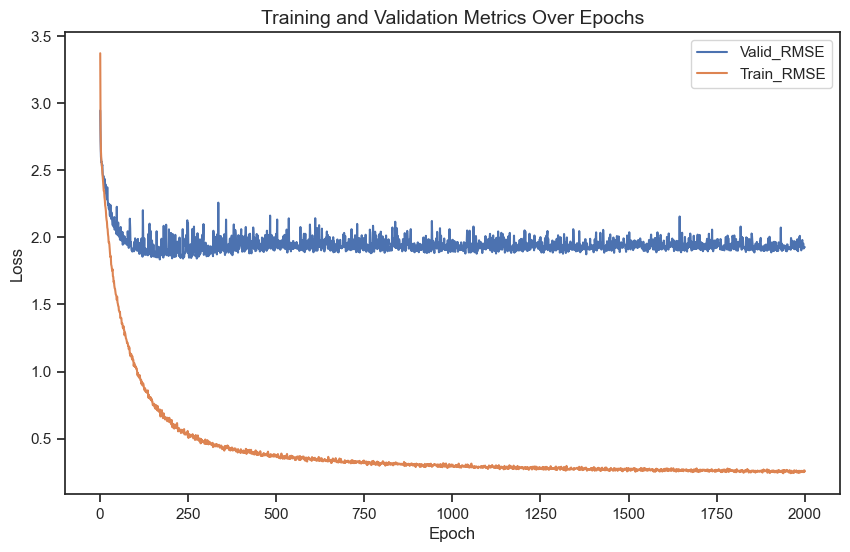

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [15]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.261549,0.261525,0.368036,0.368036,0.933060,0.965950,0.263815,NaN,1.953102,1.028199,1.028199,0.511480,0.733383,0.776502,0.515125,0.933060,1.951727
1996,1997,0.250682,0.250682,0.359190,0.359190,0.935835,0.967389,0.258224,NaN,1.916344,1.022682,1.022682,0.520674,0.734752,0.774346,0.520855,0.935836,1.914927
1997,1998,0.252900,0.252888,0.359103,0.359103,0.935270,0.967096,0.253441,NaN,1.924931,1.021799,1.021799,0.518526,0.738491,0.765843,0.521721,0.935271,1.923562
1998,1999,0.263997,0.263965,0.366609,0.366609,0.932435,0.965627,0.260321,NaN,1.926127,1.021542,1.021542,0.518227,0.737734,0.760816,0.520283,0.932436,1.924702
1999,2000,0.256371,0.256338,0.360791,0.360791,0.934387,0.966646,0.249604,NaN,1.926651,1.020989,1.020989,0.518096,0.736345,0.759109,0.518453,0.934388,1.925114


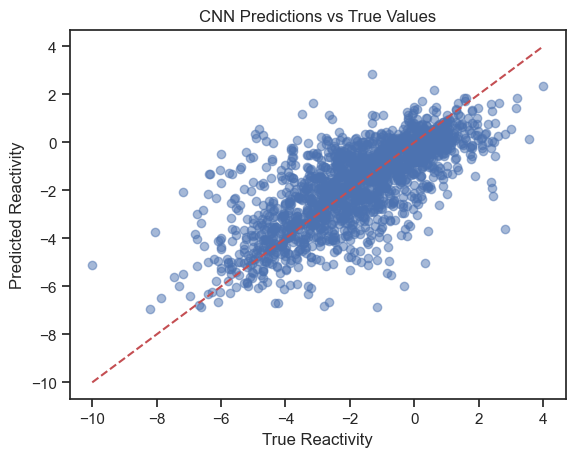

In [16]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
